<a href="https://colab.research.google.com/github/CharFox1/CompVisProj/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
from torch import nn, tensor
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
import os
import cv2
import numpy as np

In [122]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [178]:
# simple conv network to test finding single characters
# uses resnet-4 structure

class convDemoNet(nn.Module):
  def __init__(self, numClasses):
    super(convDemoNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=2)
    self.flatten = nn.Flatten()
    self.output = nn.Linear(1922, numClasses)

  def forward(self, x):
    x = x.view(-1, 1, 32, 32)
    x = F.relu(self.conv1(x))
    x = self.flatten(x)
    return self.output(x)


training data size: 78000
validation data size: 13209
training data shape: (32, 32)


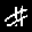

data type of image = <class 'numpy.ndarray'>
training data label: #
each index in dataset has image (32x32) and char label


In [164]:
# get conv demo data (https://www.kaggle.com/vaibhao/handwritten-characters)
from google.colab.patches import cv2_imshow #allows us to show images

# grab small files (created from larger dataset)
# this is the location they should be in the github
# if you are running in collab, you need to import the handwrittenChars folder as a zip
# you can unzip it with "!unzip handwrittenChars.zip" in a separate cell
with open("handwrittenChars/trainSmall.npy", "rb") as f:
    conv_train_data = np.load(f, allow_pickle=True)

with open("handwrittenChars/valSmall.npy", "rb") as f:
    conv_val_data = np.load(f, allow_pickle=True)

print("training data size:", len(conv_train_data))
print("validation data size:", len(conv_val_data))

print("training data shape:", conv_train_data[1201][0].shape)
cv2_imshow(conv_train_data[1201][0])
print("data type of image =", type(conv_train_data[1201][0]))
print("training data label:", conv_train_data[1201][1])
print("each index in dataset has image (32x32) and char label")

In [168]:
labels = []
for i in conv_train_data:
  label = i[1]
  if label not in labels:
    labels.append(label)

print("there are", len(labels), "labels in the training dataset")

for i in conv_val_data:
  label = i[1]
  if label not in labels:
    labels.append(label)

print("there are", len(labels), "labels in the validation dataset")

labelDict = {}
for i in range(len(labels)):
  labelDict[i] = labels[i]

print(labelDict)

there are 39 labels in the training dataset
there are 39 labels in the validation dataset
{0: '#', 1: '$', 2: '&', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9', 13: '@', 14: 'A', 15: 'B', 16: 'C', 17: 'D', 18: 'E', 19: 'F', 20: 'G', 21: 'H', 22: 'I', 23: 'J', 24: 'K', 25: 'L', 26: 'M', 27: 'N', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z'}


In [169]:
# dataset class
class handwrittenCharsDataset(Dataset):
    def __init__(self, X):
      self.images = []
      self.labels = []
      for i in X:
        self.images.append(i[0])
        self.labels.append(i[1])

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, index):
      image = self.images[index]
      label = self.labels[index]
      image = self.transform(image)
      sample = [image, label]
      return sample
    
    transform = T.Compose([
      T.ToPILImage(),
      T.ToTensor()                     
    ])

In [170]:
batch_size = 10
dataset = handwrittenCharsDataset(X=conv_train_data)
train_dl = DataLoader(dataset, batch_size, shuffle=True)

In [ ]:
for step, batch in enumerate(train_dl):
  images, labels = batch
  print(images)
  print(labels)

In [198]:
# init model with 39 classes on output layer
# put model in gpu if available
convModel = convDemoNet(39).to(device)
print(convModel)

testItem, testLabel = next(iter(train_dl))

testItem = testItem[0]
testLabel = testLabel[0]

output = convModel(testItem)
pred_prob = nn.Softmax(dim=1)(output)
y_pred = labelDict[pred_prob.argmax(1).item()]
print("predicted", y_pred, "for", testLabel)

convDemoNet(
  (conv1): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (output): Linear(in_features=1922, out_features=39, bias=True)
)
predicted 8 for @
